In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting=3)
print(f"data shape:{data.shape}")

data shape:(3150, 5)


EXPLORATORY DATA ANALYSIS

In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [5]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [6]:
data.dropna(inplace=True)

In [7]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
print(f"dataset shape after dropping null values:{data.shape}")

dataset shape after dropping null values:(3149, 5)


In [9]:
data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

Analyzing 'rating' column

In [12]:
len(data)

3149

In [13]:
print(f"Rating value count:\n {data['rating'].value_counts()}")

Rating value count:
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


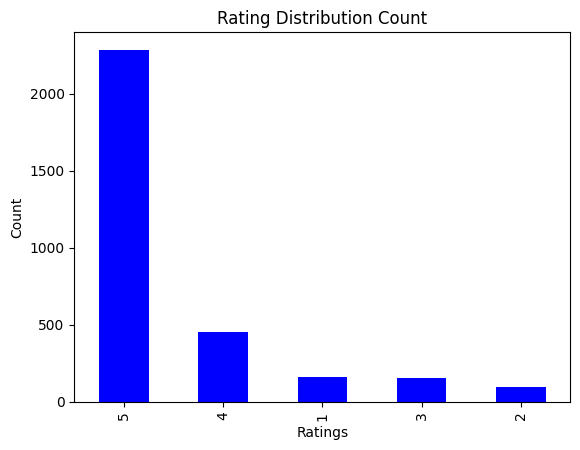

In [14]:
data['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating Distribution Count')
plt.xlabel("Ratings")
plt.ylabel('Count')
plt.show()

In [15]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [16]:
#feedback value=0

review_0=data[data['feedback']==0].iloc[0]['verified_reviews']
print(review_0)

"It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals."


In [17]:
#feedback value=1

review_1=data[data['feedback']==1].iloc[0]['verified_reviews']
print(review_1)

Love my Echo!


from above 2 examples we can observe that feedback 0 is for negative review and 1 for positive review

In [18]:
print(f"Feedback value count - Percentage Distribution: \n {round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - Percentage Distribution: 
 feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback Distribution
    -> 91.87% reviews are positive
    -> 8.13% reviews are negative

Analyzing 'variation' column

In [19]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


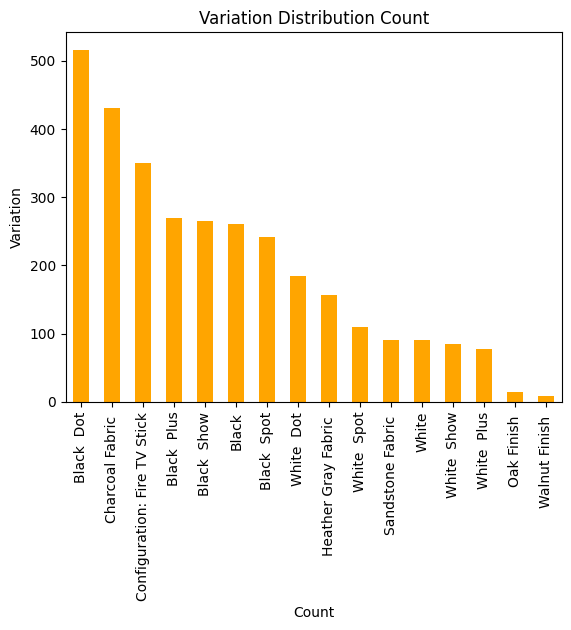

In [20]:
variation_counts = data['variation'].value_counts()
variation_counts.plot(kind='bar', color='orange')
plt.title('Variation Distribution Count')
plt.xlabel('Count')
plt.ylabel('Variation')
plt.show()

In [21]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

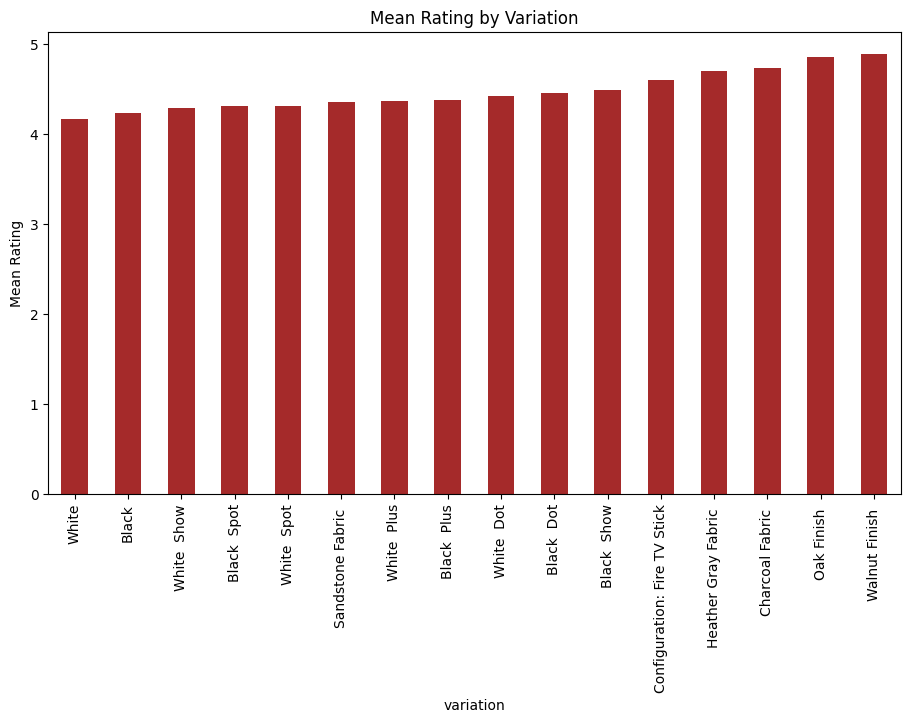

In [22]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='brown',figsize=(11,6))
plt.title('Mean Rating by Variation')
plt.xlabel('variation')
plt.ylabel('Mean Rating')
plt.show()

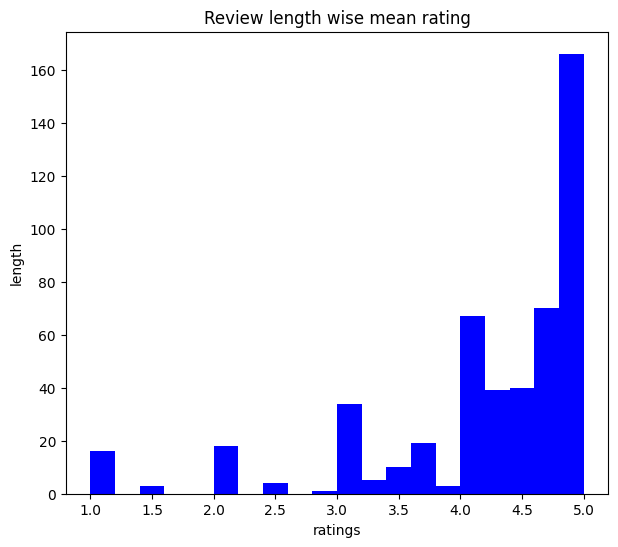

In [23]:
length_rating=data.groupby('length')['rating'].mean()
length_rating.plot(kind='hist',color='blue',figsize=(7,6),bins=20)
plt.title("Review length wise mean rating")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [24]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

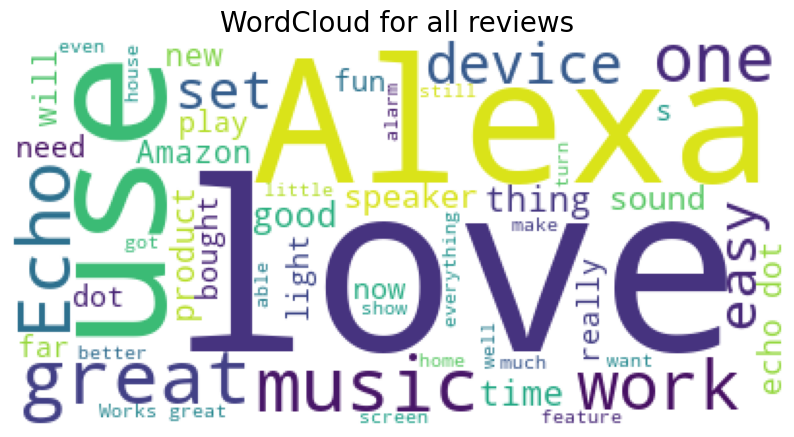

In [25]:
#combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

#Iniatilize WordCloud object
wc = WordCloud(background_color='white', max_words=50)

#Generate and plot WordCloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title("WordCloud for all reviews",fontsize=20)
plt.axis('off')
plt.show()

In [26]:
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = " ".join(unique_neg)

unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = " ".join(unique_pos)

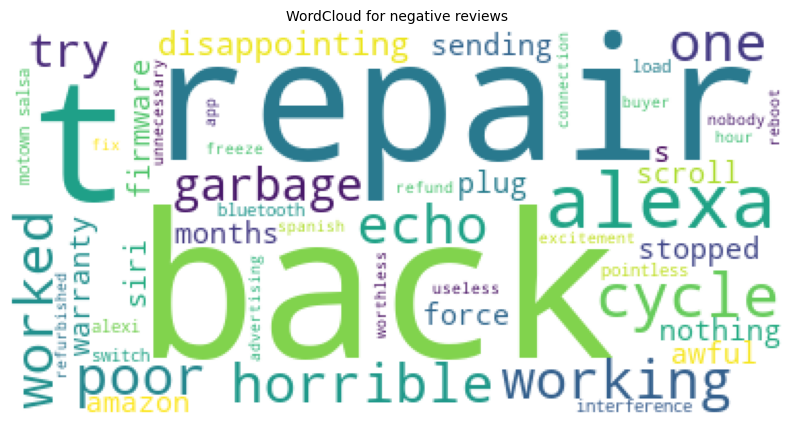

In [27]:
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neg))
plt.title("WordCloud for negative reviews",fontsize=10)
plt.axis("off")
plt.show()

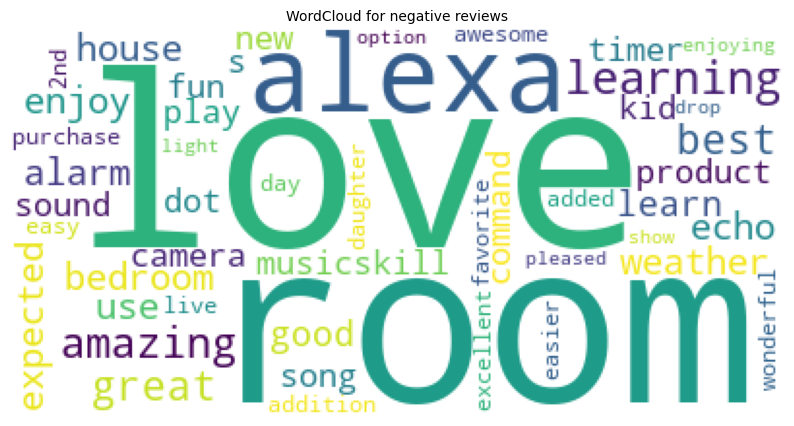

In [28]:
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_pos))
plt.title("WordCloud for negative reviews",fontsize=10)
plt.axis("off")
plt.show()

Preprocessing and Modelling

perform following:                                                                                                                    
    1.Replace any non alphabet charaters with a space                      
    2.convert to lower case and split into words                        
    3.Iterate over individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [59]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Required for some WordNet lemmatizations
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))

def preprocess_review(review):
    review = re.sub('[^a-zA-Z]', ' ', review)  # Keep only letters
    review = review.lower().split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in STOPWORDS or word in ['not', 'no', "n't"]]
    return ' '.join(review)


# corpus=[]
# stemmer=PorterStemmer()
# for i in range(0,data.shape[0]):
#     review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
#     review = review.lower().split()
#     review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
#     review = ' '.join(review)
#     corpus.append(review)

# def preprocess_review(review):
#     review = re.sub('[^a-zA-Z]', ' ', review)  # Keep only letters
#     review = review.lower().split()
#     # Retain negations and perform lemmatization
#     review = [lemmatizer.lemmatize(word) for word in review if word not in STOPWORDS or word in ['not', 'no', "n't"]]
#     return ' '.join(review)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Using CountVectorizer to create Bag of Words

In [60]:
cv = CountVectorizer(max_features=2500)

X=cv.fit_transform(corpus).toarray()
y=data['feedback'].values

In [61]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [62]:
pickle.dump(cv,open('D:/Data Science/project/CountVectorizer.pkl','wb'))

In [63]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [64]:
#train test data
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
# smote = SMOTE(random_state=42)
# X_train_resampled,y_train_resampled = smote.fit_resample(X_train, y_train)
# print(f"Resampled X_train shape: {X_train_resampled.shape}")
# print(f"Resampled y_train shape: {y_train_resampled.shape}")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (4628, 2500)
y_train: (4628,)
X_test: (1158, 2500)
y_test: (1158,)


In [65]:
sum(y_train)

2302

In [66]:
sum(y_test)

591

In [67]:
len(y_train) - sum(y_train)

2326

In [68]:
len(y_test) - sum(y_test)

567

In [69]:
print(f"X_train max value: {X_train.max()}")
print(f"X_test max value: {X_test.max()}")

X_train max value: 12
X_test max value: 6


In [70]:
scalar = MinMaxScaler()

X_train_sc1 = scalar.fit_transform(X_train)
X_test_sc1 = scalar.transform(X_test)

In [71]:
pickle.dump(scalar,open('D:/Data Science/project/scalar.pkl','wb'))

In [72]:
loaded_model_1 = pickle.load(open('D:/Data Science/project/scalar.pkl','rb'))

Random Forest Classifier

In [73]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
# Accuracy of the model
print(f"Training Accuracy:", model_rf.score(X_train_sc1,y_train))
print(f"Testing Accuracy:",model_rf.score(X_test_sc1,y_test))

Training Accuracy: 0.6467156439066551
Testing Accuracy: 0.6329879101899827


In [75]:
# Predicting on the test set
y_preds = model_rf.predict(X_test_sc1)

In [76]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_preds)

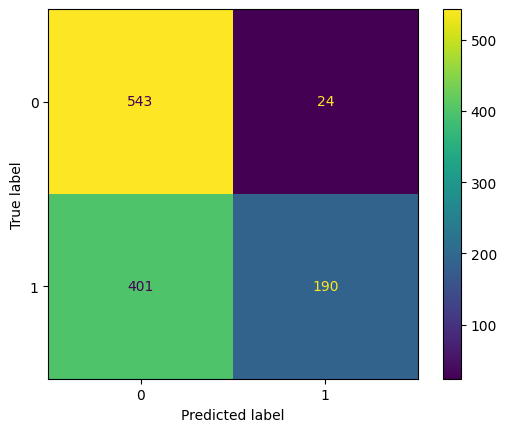

In [77]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [78]:
pickle.dump(model_rf,open('D:/Data Science/project/model_rf.pkl','wb'))

In [79]:
loaded_model_2 = pickle.load(open('D:/Data Science/project/model_rf.pkl','rb'))

XGBoost Model

In [80]:
model_xgb = XGBClassifier(scale_pos_weight=len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1]))
model_xgb.fit(X_train_sc1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
y_preds_xgb_train = model_xgb.predict(X_train_sc1)
y_preds_xgb_test = model_xgb.predict(X_test_sc1)

In [82]:
from sklearn.metrics import f1_score

In [83]:
# Accuracy of the model on training and testing data
print(f"Training Accuracy:",model_xgb.score(X_train,y_train))
print(f"Testing Accuracy:",model_xgb.score(X_test,y_test))
print(f"Training f1 score: ", f1_score(y_preds_xgb_train, y_train))
print(f"Training f1 score: ", f1_score(y_preds_xgb_test, y_test))

Training Accuracy: 0.9405790838375108
Testing Accuracy: 0.9231433506044905
Training f1 score:  0.9452488687782805
Training f1 score:  0.9217238346525946


In [84]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_preds_xgb_test)
print(cm)

[[545  22]
 [ 67 524]]


In [85]:
pickle.dump(model_xgb,open('D:/Data Science/project/model_xgb.pkl','wb'))

Here, XGBoost model is used for classification as it delivers high accuracy, prevents overfitting, and ensures fast, efficient computations with its parallelized implementation.

In [86]:
# Assuming `cv` is the CountVectorizer fitted on training data and `scaler` is the MinMaxScaler fitted on training data
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

new_reviews = [
    "I love the product! Works perfectly and is very reliable.",
    "The product stopped working after two days."
]

new_corpus = [preprocess_review(review) for review in new_reviews]

new_words = cv.transform(new_corpus).toarray()

new_words_scaled = scaler.transform(new_words)

predictions = model_xgb.predict(new_words_scaled)

for review, prediction in zip(new_reviews, predictions):
    feedback = "Positive" if prediction == 1 else "Negative"
    print(f"Review: {review}\nPrediction: {feedback}\n")


Review: I love the product! Works perfectly and is very reliable.
Prediction: Positive

Review: The product stopped working after two days.
Prediction: Negative



In [87]:
loaded_model = pickle.load(open('D:/Data Science/project/model_xgb.pkl','rb'))

In [88]:
# Assuming `cv` is the CountVectorizer fitted on training data and `scaler` is the MinMaxScaler fitted on training data
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

new_reviews = [
    "I love the product! Works perfectly and is very reliable.",
    "The product stopped working after two days."
]

new_corpus = [preprocess_review(review) for review in new_reviews]

new_words = cv.transform(new_corpus).toarray()

new_words_scaled = scaler.transform(new_words)

predictions = loaded_model.predict(new_words_scaled)

for review, prediction in zip(new_reviews, predictions):
    feedback = "Positive" if prediction == 1 else "Negative"
    print(f"Review: {review}\nPrediction: {feedback}\n")


Review: I love the product! Works perfectly and is very reliable.
Prediction: Positive

Review: The product stopped working after two days.
Prediction: Negative

